<a href="https://colab.research.google.com/github/hoangducsn00/Da-poet/blob/main/Training_GPT_2_Model_with_Huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial

In the tutorial, we are going to fine-tune a German GPT-2 from the [Huggingface model hub](https://huggingface.co/models). As fine-tune, data we are using the [German Recipes Dataset](https://www.kaggle.com/sterby/german-recipes-dataset), which consists of 12190 german recipes with metadata crawled from [chefkoch.de](http://chefkoch.de/).

The idea is we use the recipe description to fine-tune our GPT-2 to let us write recipes we can cook.

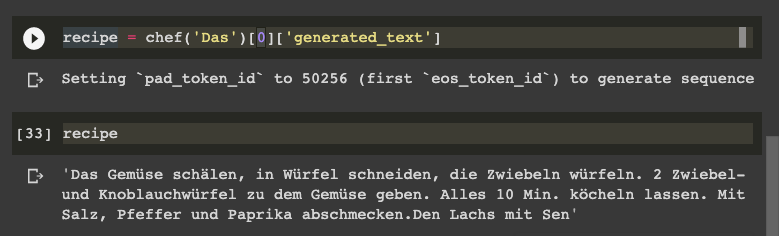

I am using Google Colab with a GPU runtime for this tutorial. If you are not sure how to use a GPU Runtime take a look here.

In [ ]:
!nvidia-smi

Mon Nov  2 17:50:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **What are we going to do:**

- load the dataset from kaggle
- prepare the dataset and build a ``TextDataset``
- load the pre-trained GPT-2 model and tokenizer
- initialize ``Trainer`` with ``TrainingArguments``
- train and save the model
- test the model

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 10.4MB/s 
     |████████████████████████████████| 1.1MB 49.6MB/s 
     |████████████████████████████████| 890kB 51.9MB/s 
     |████████████████████████████████| 2.9MB 27.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ba1237ccb43abb9db6ad174b0063a890503e6b1a71bccf46e09c6f38a818a0f9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Da Poet/VNTQcorpus-big'
!ls

/content/drive/My Drive/Da Poet/VNTQcorpus-big
checkpoint-10000  checkpoint-30000  config.json       pytorch_model.bin
checkpoint-20000  checkpoint-40000  log_history.json  training_args.bin


After we uploaded the file with use `unzip` to extract the recipes.json. 

# Prepare the dataset and build a ``TextDataset``

The next step is to extract the instructions from all recipes and build a `TextDataset`. The `TextDataset` is a custom implementation of the [Pytroch `Dataset` class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class) implemented by the transformers library. If you want to know more about Dataset in Pytroch you can check out this [youtube video](https://www.youtube.com/watch?v=PXOzkkB5eH0&ab_channel=PythonEngineer).

First, we are going to split the `recipes.json` into a `train` and `test` section and extract `Instructions` from the recipes and write them into a `train_dataset.txt` and `test_dataset.txt`

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

#phobert = AutoModel.from_pretrained("vinai/phobert-base")
custokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
custokenizer.add_tokens('\n')

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


1

In [ ]:
train_path = '/content/drive/My Drive/Da Poet/68cleanregex.txt'
test_path = '/content/drive/My Drive/Da Poet/68cleanvl_test.txt'

In [ ]:
import os
import torch
from torch.utils.data.dataset import Dataset
from transformers.tokenization_utils import PreTrainedTokenizer
from filelock import FileLock
from transformers.utils import logging
from typing import Dict, List, Optional
import pickle
import random
import time

logger = logging.get_logger(__name__)
class CusTextDataset(Dataset):
    """
    This will be superseded by a framework-agnostic approach
    soon.
    """

    def __init__(
        self,
        tokenizer: PreTrainedTokenizer,
        file_path: str,
        block_size: int,
        overwrite_cache=False,
        cache_dir: Optional[str] = None,
    ):
        assert os.path.isfile(file_path), f"Input file path {file_path} not found"

        block_size = block_size - tokenizer.num_special_tokens_to_add(pair=False)

        directory, filename = os.path.split(file_path)
        cached_features_file = os.path.join(
            cache_dir if cache_dir is not None else directory,
            "cached_lm_{}_{}_{}".format(
                tokenizer.__class__.__name__,
                str(block_size),
                filename,
            ),
        )

        # Make sure only the first process in distributed training processes the dataset,
        # and the others will use the cache.
        lock_path = cached_features_file + ".lock"
        with FileLock(lock_path):

            if os.path.exists(cached_features_file) and not overwrite_cache:
                start = time.time()
                with open(cached_features_file, "rb") as handle:
                    self.examples = pickle.load(handle)
                logger.info(
                    f"Loading features from cached file {cached_features_file} [took %.3f s]", time.time() - start
                )

            else:
                logger.info(f"Creating features from dataset file at {directory}")

                self.examples = []
                with open(file_path, encoding="utf-8") as f:
                    text = f.read()

                tokenized_text = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))

                # for i in range(0, len(tokenized_text) - block_size + 1, block_size):  # Truncate in block of block_size
                i = 0
                while i < len(tokenized_text) - block_size + 1:
                    inds = tokenized_text[i : i + block_size]
                    for j in range(0, len(inds)):
                        if inds[j]==64001:
                            inds = inds[j+1:] #remove the first \n
                            break
                    for j in range(len(inds)-1, 0, -1):
                        if inds[j]==64001:
                            inds = inds[:j-1] #remove \n
                            break
                    i += len(inds)
                    self.examples.append(
                        tokenizer.build_inputs_with_special_tokens(inds)
                    )
                # Note that we are losing the last truncated example here for the sake of simplicity (no padding)
                # If your dataset is small, first you should loook for a bigger one :-) and second you
                # can change this behavior by adding (model specific) padding.

                start = time.time()
                with open(cached_features_file, "wb") as handle:
                    pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)
                logger.info(
                    "Saving features into cached file %s [took %.3f s]", cached_features_file, time.time() - start
                )

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i) -> torch.Tensor:
        return torch.tensor(self.examples[i], dtype=torch.long)

In [ ]:
from transformers import LineByLineTextDataset, DataCollatorForLanguageModeling, LineByLineWithSOPTextDataset

def load_dataset(train_path, test_path, tokenizer):
    train_dataset = CusTextDataset(
          tokenizer=custokenizer,
          file_path=train_path,
          block_size=256)
     
    test_dataset = CusTextDataset(
          tokenizer=custokenizer,
          file_path=test_path,
          block_size=256)   
    
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=custokenizer, mlm=False,
    )
    return train_dataset,test_dataset,data_collator

train_dataset,test_dataset,data_collator = load_dataset(train_path,test_path,custokenizer)

In [ ]:
len(test_dataset)

52

In [ ]:
print(custokenizer.decode(train_dataset[1]))

<s> tìm về nơi ấy dòng sông 
 mẹ tôi vẫn đứng chờ mong sang đò 
 tìm về cái thuở học trò 
 sân trường lưu luyến hẹn hò mùa thi 
 tìm về ánh mắt chia ly 
 cầm tay chẳng biết nói gì với nhau 
 hạ ơi ngày ấy còn đâu 
 tiếng ve tha thiết vẫn rầu rĩ kêu 
 bâng khuâng nghe tiếng sáo diều 
 hồn tôi như lạc vào chiều hạ xưa 
 
 nghe câu vọng cổ nhà quê 
 ngỡ như cánh võng tiếng bà ru tôi 
 
 tìm trong lưu luyến hạ ơi 
 tay nâng cánh phượng một thời tuổi hoa 
 đâu rồi ngày tháng đã qua 
 còn trong ký ức nhạt nhòa buồn vui 
 gió lùa cánh phượng nghiêng rơi 
 theo vầng mây trắng êm trôi bềnh bồng 
 thương sao những cánh phượng hồng 
 ép trang vở mới thơm nồng vấn vương 
 chiều nay trở lại con đường 
 bạn bè hai buổi đến trường năm xưa 
 vẫn chùm phượng nở nắng mưa 
 màu hoa đỏ thắm đong đưa lối về 
 ai thả cánh phượng sông quê 
 lênh đênh trôi mãi biết về nơi đâu 
 
 dẫu rằng bên lở bên bồi 
 nghìn năm vẫn nhẫn nại trôi một dòng 
 dẫu rằng lúc đục khi trong 
 cũng không ăn ở hai lòng với </s>


# Initialize `Trainer` with `TrainingArguments` and GPT-2 model

The [Trainer](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Trainer) class provides an API for feature-complete training. It is used in most of the [example scripts](https://huggingface.co/transformers/examples.html) from Huggingface. Before we can instantiate our `Trainer` we need to download our GPT-2 model and create a [TrainingArguments](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments) to access all the points of customization during training. In the `TrainingArguments`, we can define the Hyperparameters we are going to use in the training process like our `learning_rate`, `num_train_epochs`, or  `per_device_train_batch_size`. A complete list can you find [here](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments).

In [ ]:
from transformers import Trainer, TrainingArguments, GPT2Config, GPT2LMHeadModel

#PRETRAINED GPT VNTQ

In [ ]:
vntq = GPT2LMHeadModel.from_pretrained('/content/drive/My Drive/Da Poet/VNTQcorpus-big')

In [ ]:
vntq

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(64002, 768)
    (wpe): Embedding(258, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Layer

In [ ]:
vntq.lm_head.weight

Parameter containing:
tensor([[-5.0537e-03,  1.5266e-02,  7.1732e-05,  ...,  2.4746e-03,
          3.7798e-02, -7.7541e-03],
        [-3.5096e-02,  1.7713e-02, -7.5769e-02,  ..., -5.9570e-02,
          5.5791e-02, -7.8424e-02],
        [-1.4705e-01, -2.8998e-02, -1.0895e-01,  ..., -9.7569e-02,
          2.4534e-02, -3.5935e-02],
        ...,
        [-5.2446e-02,  2.8168e-02, -6.7883e-02,  ..., -2.6638e-02,
          6.4592e-03, -5.8715e-02],
        [-3.8043e-02,  4.8344e-03, -3.0653e-02,  ..., -2.9550e-02,
          8.9412e-02, -3.1691e-02],
        [-5.6870e-02,  4.1996e-02, -4.6210e-02,  ..., -5.2594e-02,
          3.7680e-02, -5.7119e-02]], requires_grad=True)

Re-create weight FC layer to fine-tuning

In [ ]:
rand_weight = torch.rand(vntq.lm_head.weight.shape)

In [ ]:
vntq.lm_head.weight = torch.nn.parameter.Parameter(rand_weight)

In [ ]:
vntq.lm_head.weight

Parameter containing:
tensor([[0.8076, 0.2626, 0.9621,  ..., 0.4114, 0.3060, 0.8154],
        [0.6863, 0.5841, 0.4815,  ..., 0.0548, 0.2704, 0.0082],
        [0.4930, 0.2239, 0.9287,  ..., 0.1257, 0.8200, 0.5614],
        ...,
        [0.0949, 0.5927, 0.9522,  ..., 0.8103, 0.6593, 0.5268],
        [0.9307, 0.7713, 0.1733,  ..., 0.3537, 0.5737, 0.0712],
        [0.9450, 0.3969, 0.6747,  ..., 0.0913, 0.9688, 0.6299]],
       requires_grad=True)

In [ ]:
vntq.config

GPT2Config {
  "_name_or_path": "/content/drive/My Drive/Da Poet/VNTQcorpus-big",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "embd_pdrop": 0.1,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 258,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 258,
  "pad_token_id": 1,
  "resid_pdrop": 0.1,
  "sep_token_id": 2,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "total_flos": 132102113022443520,
  "vocab_size": 64002
}

# NEW MODEL

In [ ]:
task = {"text-generation": {"do_sample": True, "max_length": 256}} #edit output size

In [ ]:
configuration = GPT2Config(vocab_size=64002, n_positions=258, n_ctx=258,
                           task_specific_params=task,
                           eos_token_id=custokenizer.eos_token_id,
                           bos_token_id=custokenizer.bos_token_id, 
                           pad_token_id=custokenizer.pad_token_id,
                           sep_token_id=custokenizer.sep_token_id
                           )
poem = GPT2LMHeadModel(configuration)
poem

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(64002, 768)
    (wpe): Embedding(258, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Layer

In [ ]:
poem.config

GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "embd_pdrop": 0.1,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 258,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 258,
  "pad_token_id": 1,
  "resid_pdrop": 0.1,
  "sep_token_id": 2,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 256
    }
  },
  "vocab_size": 64002
}

Copying weight from VNQT trained model to the new one

In [ ]:
poem.load_state_dict(vntq.state_dict())

<All keys matched successfully>

In [ ]:
from transformers.trainer_callback import TrainerCallback
from transformers import pipeline
class PrinterCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, model=None, **kwargs):
        if int(state.epoch)%10==0:
            pipe = pipeline('text-generation', model=model, tokenizer=custokenizer, device=0)
            with open("/content/drive/My Drive/Da Poet/sample.txt", "a") as f:
                f.write(pipe('<s> tìm về một thuở hạ xưa')[0]['generated_text'])
                f.write("\n===========================================\n")
                f.close()

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/My Drive/Da Poet/gpt2-vnmesepoem", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=200, # number of training epochs
    per_device_train_batch_size=16, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    save_steps=10000, # after # steps model is saved 
    save_total_limit = 2, # delete other checkpoints
    warmup_steps=500,    # number of warmup steps for learning rate scheduler
    logging_dir='/content/drive/My Drive/Da Poet/gpt2-vnmesepoem/logs', # directory for storing logs
    logging_steps=500,
    )

In [ ]:
trainer = Trainer(
    model=poem,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    prediction_loss_only=True,
    callbacks = [PrinterCallback],
)

/usr/local/lib/python3.6/dist-packages/transformers/trainer.py:263: FutureWarning: Passing `prediction_loss_only` as a keyword argument is deprecated and won't be possible in a future version. Use `args.prediction_loss_only` instead. Setting `args.prediction_loss_only=True
  FutureWarning,


# Train and save the model

To train the model we can simply run `Trainer.train()`.

After training is done you can save the model by calling `save_model()`. This will save the trained model to our `output_dir` from our `TrainingArguments`.

In [ ]:
trainer.train()
trainer.save_model()

# Test the model

To test the model we are going to use another [highlight of the transformers library](https://huggingface.co/transformers/main_classes/pipelines.html?highlight=pipelines) called `pipeline`. [Pipelines](https://huggingface.co/transformers/main_classes/pipelines.html?highlight=pipelines) are objects that offer a simple API dedicated to several tasks, among others also `text-generation`

In [ ]:
from transformers import pipeline

poem = pipeline('text-generation', model="/content/drive/My Drive/gpt2-vnmesepoem", tokenizer=custokenizer, device=0)

In [ ]:
a = poem('<s> có làm thì mới có ăn')

In [ ]:
print(a[0]['generated_text'])

<s> có làm thì mới có ăn 
 mất lời hoá cõi đức vua sửa sang 
 lược kinh lớn nói một toà 
 khiến người hiệu thụ các nơi thuỷ chung 
 thờ ơ tóc ấy đều lầm 
 dương từ hà mậu lòng thêm phần 
 rước
